In [41]:
import random
import numpy as np

import plotly.express as px
 

## Simple movement maths
Deers have a home range. 
They move randomly but if they stray too far from the centroid they turn towards it. 

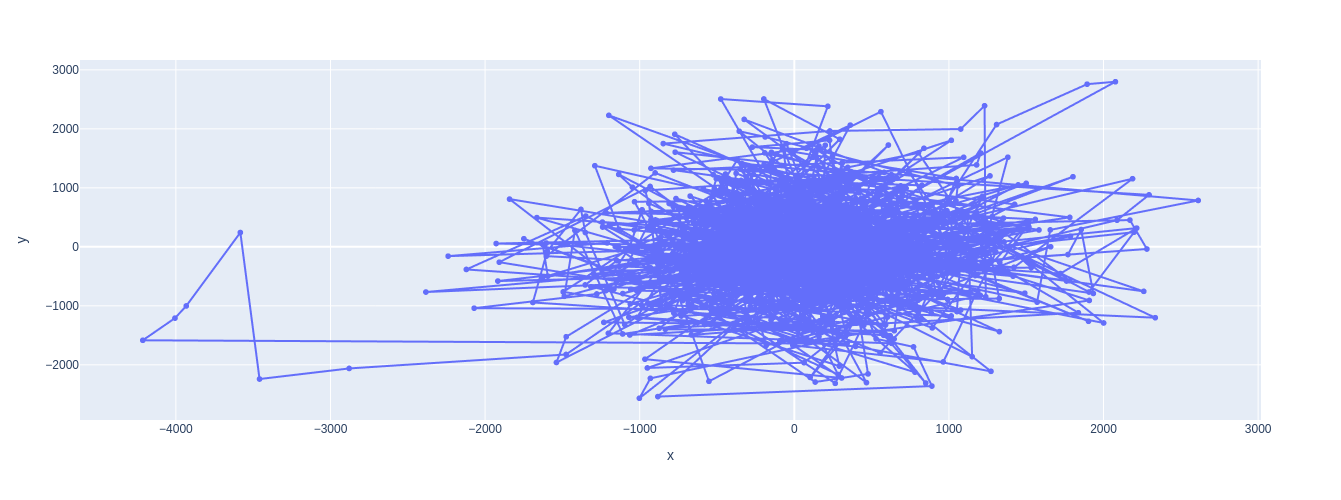

In [80]:
# Deer has a home range of 3 units centered around (0,0)

this_seed = 1234

centroid_x = 100
centroid_y = -100
home_range_d = 100
speed_scaling_factor = 1000


x = 0
y = 0

x_history = [x]
y_history = [y]
for tick in range(1000):
    rng = np.random.default_rng(this_seed+tick)
    x_delta, y_delta = rng.standard_normal(2)*speed_scaling_factor

    # Check if X and Y components are too far away from centroid
    # And if so, change sign of delta to move towards centroid
    if centroid_x - x > home_range_d:
        x_delta = abs(x_delta) # Make next X component towards centroid
    elif x - centroid_x > home_range_d:
        x_delta = 0 - abs(x_delta) # Make next X component towards centroid

    if centroid_y - y > home_range_d:
        y_delta = abs(y_delta) # Make next X component towards centroid
    elif y - centroid_y > home_range_d:
        y_delta = 0 - abs(y_delta) # Make next X component towards centroid

    # Step
    x = x + x_delta
    y = y + y_delta
    
    x_history.append(x)
    y_history.append(y)

fig = px.line(x=x_history,
              y=y_history,
              markers=True,
              width=500,
              height=500,)
fig.show()

In [64]:

from repast4py.parameters import create_args_parser, init_params

In [75]:
parameters_file = 'deer_config.yaml'

parser = create_args_parser()
# args = parser.parse_aergs()
params = init_params(parameters_file, '{}')
params 

{'sim': {'end_tick': 30, 'num_deer_agents': 30, 'environment': 'local'},
 'files': {'input_agents': 'input/deer_agents.parq'},
 'logging': {'agent_log_file': 'output/agent_log.csv'}}

In [78]:
params['sim']['end_tick']

30